In [796]:
# -*- coding:utf-8 -*-
import os
import numpy as np
from numpy import array
from skimage.color import rgb2ycbcr
from skimage.color import ycbcr2rgb
from skimage.measure import compare_psnr
from skimage.measure import compare_ssim
from scipy.signal import medfilt
from scipy.ndimage.filters import gaussian_filter
from scipy.misc import imresize
from scipy.signal import convolve
from skimage.util import view_as_windows
import  skimage.io as io
from skimage import data_dir
from sklearn.decomposition import dict_learning_online
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import sparse_encode
from scipy.io import loadmat
from scipy.io import savemat
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from math import log
from itertools import product
from sklearn.decomposition import PCA
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC
import copy

dic_size = 1024
Lambda = 0.2
upscale = 2
nSmp = 50000
patch_size = 5
overlap = 4

In [1171]:
def image_set_preprocessing(X, y, batch_ratio = 1, pad_size=2, pad_method='constant'):
    X_pad = np.pad(X, ((0,0),(pad_size,pad_size),(pad_size,pad_size)), 'constant')
    
    batch_size = (int)(X_pad.shape[0]*batch_ratio)
    
    X_pad_shuffle = X_pad
    y_shuffle = y

    X_train_batch = ((X_pad_shuffle[0:batch_size, :, :]).astype('float32'))/255
    y_train_batch = y_shuffle[0:batch_size,]
    X_train_batch = X_train_batch.reshape(X_train_batch.shape[0], X_train_batch.shape[1], X_train_batch.shape[2], 1)
    
    return X_train_batch, y_train_batch

def image_set_preprocessing_v2(X, y, batch_ratio = 1, pad_size=2, pad_method='constant'):
    X_pad = np.pad(X, ((0,0),(pad_size,pad_size),(pad_size,pad_size)), 'constant')
    
    batch_size = (int)(X_pad.shape[0]*batch_ratio)
    
    order = np.array(range(X_pad.shape[0]))
    np.random.shuffle(order)
    X_pad_shuffle = X_pad[order]
    y_shuffle = y[order]

    X_train_batch = ((X_pad_shuffle[0:batch_size, :, :]).astype('float32'))/255
    for i in range(X_train_batch.shape[0]):
        X_train_batch[i,:,:] = random_noise(X_train_batch[i,:,:], clip=True)
    y_train_batch = y_shuffle[0:batch_size,]
    X_train_batch = X_train_batch.reshape(X_train_batch.shape[0], X_train_batch.shape[1], X_train_batch.shape[2], 1)
    
    return X_train_batch, y_train_batch

def flatten_patches(cubio, size):
    window_shape = (1,size,size,cubio.shape[3])
    step = (1,size,size,cubio.shape[3])
    patches = view_as_windows(cubio, window_shape, step)
    patches = patches.squeeze(axis = (3,4))
    patches_panel = patches.reshape(-1, patches.shape[-3]*patches.shape[-2]*patches.shape[-1])
    
    return patches_panel

def remove_low_variance(patches_panel,thr=100):
    var = np.var(patches_panel, axis = 1)
    patches_clean = patches_panel[var>thr]
    
    return patches_clean

def remove_patches_mean(patches):
    mean = patches.mean(axis = 1)
    patches_mean_remov = (patches.T-mean).T
    
    return patches_mean_remov

def pca_kernel(patches, n_comps, kernel):
    pca = PCA(n_components = n_comps,whiten = True)
    pca.fit(patches)
    kernel.append(pca)  
       
def pca_transform(kernel, window_size, layer, patches_mean_remov, patches_panel, X_train):
    n_sample = X_train.shape[0]
    h = (int)(X_train.shape[1]/window_size[layer-1])
    w = (int)(X_train.shape[2]/window_size[layer-1])
    patches_proj = k[layer-1].transform(patches_mean_remov)
    patches_proj = k[layer-1].inverse_transform(patches_proj)
    cubio_trans = patches_proj.reshape(n_sample,h,w,window_size[layer-1],window_size[layer-1])
    cubio_trans = np.swapaxes(cubio_trans, 2, 3)
    cubio_pca = cubio_trans.reshape(n_sample,X_train.shape[1],X_train.shape[2])
    #dc = patches_panel.mean(axis=1)*2
    #dc = dc.reshape(n_sample, h, w, -1)
    #cubio_next = np.concatenate((cubio_pca, dc), axis=3)
    
    return cubio_pca

def pca_transform_v2(kernel, window_size, layer, patches_mean_remov, patches_panel, X_train):
    n_sample = X_train.shape[0]
    h = (int)(X_train.shape[1]/window_size[layer-1])
    w = (int)(X_train.shape[2]/window_size[layer-1])
    patches_proj = k[layer-1].transform(patches_mean_remov)
    cubio_pos = patches_proj.reshape(n_sample,h,w,-1)
    cubio_neg = -cubio_pos
    cubio_pca = np.concatenate((cubio_pos, cubio_neg), axis=3)
    dc = patches_panel.mean(axis=1)*2
    dc = dc.reshape(n_sample, h, w, -1)
    cubio_next = np.concatenate((cubio_pca, dc), axis=3)
    
    return cubio_next

def pca_transform_v3(kernel, window_size, layer, patches_mean_remov, patches_panel, X_train):
    n_sample = X_train.shape[0]
    h = (int)(X_train.shape[1]/window_size[layer-1])
    w = (int)(X_train.shape[2]/window_size[layer-1])
    patches_proj = k[layer-1].transform(patches_mean_remov)
    cubio_pos = patches_proj.reshape(n_sample,h,w,-1)
    dc = patches_panel.mean(axis=1)*2
    dc = dc.reshape(n_sample, h, w, -1)
    cubio_next = np.concatenate((cubio_pos, dc), axis=3)
    
    return cubio_next

def pca_transform_v4(kernel, window_size, layer, patches_mean_remov, X_train):
    n_sample = X_train.shape[0]
    h = (int)(X_train.shape[1]/window_size[layer-1])
    w = (int)(X_train.shape[2]/window_size[layer-1])
    patches_proj = k[layer-1].transform(patches_mean_remov)
    cubio_pos = patches_proj.reshape(n_sample,h,w,-1)
    
    return cubio_pos

def relu(cubio):
    cubio_relu = cubio * (cubio > 0)
    
    return cubio_relu

def tanh(cubio):
    cubio_tanh = np.divide(np.exp(cubio), 1+np.exp(cubio))
    
    return cubio_tanh

def modcrop(Input_Img, upscale = 1, H_min = 0, W_min = 0):
    if upscale != 1:
        mod = np.remainder(Input_Img.shape, upscale)
        new_shape = Input_Img.shape - mod
        Output_Img = Input_Img[0:new_shape[0], 0:new_shape[1]]
    else:
        Output_Img = Input_Img[0:H_min, 0:W_min]
    
    return Output_Img
    
def one_stage_training(layer, n_comps, kernel, feature_list, window_size, X):
    print("training at the %dth layer ..." %(layer))
    X = modcrop(X, window_size[layer-1])
    cubio = X.reshape(1, X.shape[0], X.shape[1], -1)
    patches_panel = flatten_patches(cubio, window_size[layer-1])
    if layer == 1:
        patches_mean_remov = remove_patches_mean(patches_panel)
    else:
        patches_mean_remov = patches_panel
    patches_clean = remove_low_variance(patches_mean_remov)
    pca_kernel(patches_clean, n_comps[layer-1], k)
    cubio_next = pca_transform(k, window_size, layer, patches_mean_remov, patches_panel, cubio)
    feature_list.append(cubio_next)
    print("Done! the shape of output cubio is %s." %(cubio_next.shape,))

def feature_fusion(feature_list, num_layers):
    feature = feature_list[0].reshape(feature_list[0].shape[0], -1)
    for i in range(num_layers-1):
        feature = np.concatenate((feature,feature_list[i+1].reshape(feature_list[i+1].shape[0], -1)), axis=1)
    print("the shape of features we get is %s." %(feature.shape,))
    return feature

def Reduce_Feature(n_comps, feature):
    pca = PCA(n_components = n_comps)
    X_pc = pca.fit_transform(feature)
    print("the number of dimensions kept is %d." %(X_pc.shape[1]))
    
    return X_pc, pca

def F_test(percent, feature, label):
    Ftest = SelectPercentile(chi2, percent)
    X_f = Ftest.fit_transform(feature, label)
    print("the number of feature dimensions passing F-test is %d." %(X_f.shape[1]))

    return X_f, Ftest

def one_stage_testing(layer, kernel, feature_list, X):
    print("training at the %dth layer ..." %(layer))
    patches_panel = flatten_patches(X, pow(2,layer))
    patches_mean_remov = remove_patches_mean(patches_panel)
    cubio_next = pca_transform(kernel, layer, patches_mean_remov, patches_panel, X)
    feature_list.append(cubio_next)
    print("Done! the shape of output cubio is %s." %(cubio_next.shape,))

# Training

variable need to set up: <br>
dict_size (dictionary size) <br>
lambda (sparsity regularization) <br>
maybe patch_size (image patch size) <br>
nSmp (number of patches to sample) <br>
upscale (upscale factor) <br>

## ramdomly sample image patches <br>
patches_size, nSmp, upscale, img_path

read images from img_path

In [1089]:
str = '/Users/shanlinsun/Desktop/USC/2018_Summer/ScSR/Data/Training/*.bmp'
coll = io.ImageCollection(str)
Image_collection = []
L_Image_collection = []
M_Image_collection = []
RI_Image_collection = [] 
h = np.zeros(len(coll))
w = np.zeros(len(coll))

for i in range(len(coll)):
    if coll[i].shape[2] == 3:
        G_Img = rgb2ycbcr(coll[i])
        # only keep y-channle for 'texture'
        Image_collection.append(G_Img[:,:,0])
    else:
        Image_collection.append(coll[i])
        
    Image_collection[i] = modcrop(Image_collection[i], upscale = 8)

In [1090]:
for i in range(len(coll)):
    L_Image_collection.append(imresize(Image_collection[i], 1/upscale, interp='bicubic', mode = 'F'))
    M_Image_collection.append(imresize(L_Image_collection[i], Image_collection[i].shape, interp='bicubic', mode = 'F'))
    RI_Image_collection.append(Image_collection[i]-M_Image_collection[i])

/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


train modified saak transform

In [1175]:
#prepare training parameters list
k = []
feature_list = []
feature_list.append([])
feature_list.append([])
feature_list.append([])
cubio = []
cubio.append([])
cubio.append([])
cubio.append([])
cubio.append([])
n_comps = [2, 2, 2]
patch_size = [1, 2, 4]
window_size = np.dot(patch_size, upscale)

for j in range(len(coll)):
    X = modcrop(M_Image_collection[j], 8)
    cubio[0].append(X.reshape(1, X.shape[0], X.shape[1], -1))


for i in range(3):
    layer = i+1
    patches_panel = []
    patches_mean_remov = []
    for j in range(len(coll)):
        patches_panel.append(flatten_patches(cubio[0][j], window_size[i]))
        patches_mean_remov.append(remove_patches_mean(patches_panel[j]))
        
        if i == 0:
            if j == 0:
                patches_clean = remove_low_variance(patches_mean_remov[j])
            else:
                patches_clean = np.concatenate((patches_clean, remove_low_variance(patches_mean_remov[j])), axis=0)
        else:
            if j == 0:
                patches_clean = patches_mean_remov[j]
            else:
                patches_clean = np.concatenate((patches_clean, patches_mean_remov[j]), axis=0)

    pca_kernel(patches_clean, n_comps[i], k)
    for j in range(len(coll)):
        img_tmp = pca_transform_v4(k, window_size, layer, patches_mean_remov[j], cubio[0][j])
        feature_list[i].append(img_tmp)

for j in range(len(coll)):
    feature_l_1 = flatten_patches(feature_list[0][j], 4)
    feature_l_2 = flatten_patches(feature_list[1][j], 2)
    feature_l_3 = feature_list[2][j].reshape(feature_list[2][j].shape[1]*feature_list[2][j].shape[2],-1)
    feature_l = np.concatenate((feature_l_1, feature_l_2, feature_l_3),axis = 1)
    if j == 0:
        Feature_l = feature_l
    else:
        Feature_l = np.concatenate((Feature_l, feature_l), axis=0)       

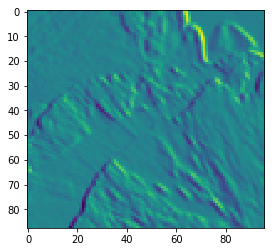

In [1173]:
plt.imshow(feature_list[0][0][0,:,:,0])

In [1176]:
#prepare training parameters list
feature_list_h = []
feature_list_h.append([])
feature_list_h.append([])
feature_list_h.append([])
cubio = []
cubio.append([])
cubio.append([])
cubio.append([])
cubio.append([])
n_comps = [2, 2, 2]
patch_size = [1, 2, 4]
window_size = np.dot(patch_size, upscale)

for j in range(len(coll)):
    X = modcrop(Image_collection[j], 8)
    cubio[0].append(X.reshape(1, X.shape[0], X.shape[1], -1))


for i in range(3):
    layer = i+1
    for j in range(len(coll)):
        patches_panel = flatten_patches(cubio[0][j], window_size[i])
        patches_mean_remov = remove_patches_mean(patches_panel)
        img_tmp = pca_transform_v4(k, window_size, layer, patches_mean_remov, cubio[0][j])
        feature_list_h[i].append(img_tmp)

for j in range(len(coll)):
    feature_h_1 = flatten_patches(feature_list_h[0][j], 4)
    feature_h_2 = flatten_patches(feature_list_h[1][j], 2)
    feature_h_3 = feature_list_h[2][j].reshape(feature_list_h[2][j].shape[1]*feature_list_h[2][j].shape[2],-1)
    feature_h = np.concatenate((feature_h_1, feature_h_2, feature_h_3),axis = 1)
    if j == 0:
        Feature_h = feature_h
    else:
        Feature_h = np.concatenate((Feature_h, feature_h), axis=0) 

/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


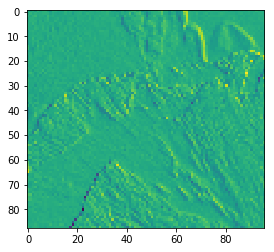

In [1177]:
plt.imshow(feature_list_h[0][0][0,:,:,0])

apply pca to low-res feature

In [1183]:
from sklearn.decomposition import PCA
clf = PCA(n_components=30)
Feature_l_pca = clf.fit_transform(Feature_l)
Feature_h_pca = clf.transform(Feature_h)

threshold = 0.2
idx = np.var(Feature_l_pca,1)>0.2
Feature_l_pca = Feature_l_pca[idx,:]
Feature_h_pca = Feature_h_pca[idx,:]

Feature_pca = np.concatenate((Feature_l_pca, Feature_h_pca), axis = 1)

### slice out patches from images

slice out low-res feature patches ans high-res patches

In [1181]:
window_size = 8
step = 8
for i in range(len(coll)):
    
    # slice out residual patches
    patch_array_ri = view_as_windows(RI_Image_collection[i], window_size, step)
    patch_array_ri = patch_array_ri.reshape(-1, patch_array_ri.shape[-2]*patch_array_ri.shape[-1])
    
    if i == 0:
        feature_ri = patch_array_ri
    else:
        feature_ri = np.concatenate((feature_ri,patch_array_ri),axis = 0)

In [1194]:
Feature_ri = feature_ri[idx, :]

In [1196]:
code, Dic = dict_learning_online(Feature_pca, n_components = dic_size, alpha = 0.1, n_iter = 50, batch_size = 500, verbose = 20)

Iteration   0 (elapsed time:   1s,  0.0mn)
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new ran

Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new 

Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new 

[optional] save patches arrays

## train coupled dictionary<br>
low-res patches array, high-res patches array<br>
dict-size, lambda

spase coding (sklearn)

In [1197]:
from numpy.linalg import inv
Dh = np.dot(inv(np.dot(code.T, code)), np.dot(code.T, Feature_ri))

# Testing

read the test image

In [1198]:
Gnd_Img = io.imread('/Users/shanlinsun/Desktop/USC/2018_Summer/ScSR/Data/Testing/gnd.bmp')
T_Img = io.imread('/Users/shanlinsun/Desktop/USC/2018_Summer/ScSR/Data/Testing/input.bmp')

convert rgb image to ycbcr image, only use the y-channel image only later

In [1199]:
Gnd_Img_ycbcr = rgb2ycbcr(Gnd_Img)
T_Img_ycbcr = rgb2ycbcr(T_Img)
M_Img = imresize(T_Img_ycbcr[:,:,0],(Gnd_Img.shape[0],Gnd_Img.shape[1]), interp='bicubic', mode = 'F')

/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


## ScSR<br>
up_scale<br>
lambda<br>
overlap, the lager the better result

feature extraction via modified saak transform

In [572]:
X = modcrop(M_Img, 8)
X_h = modcrop(Gnd_Img_ycbcr[:,:,0], 8)
window_size = [2, 4, 8]
cubio = X.reshape(1, X.shape[0], X.shape[1], -1)
cubio_h = X_h.reshape(1, X_h.shape[0], X_h.shape[1], -1)
M_feature_list = []
H_feature_list = []

for i in range(3):
    
    layer = i+1
    
    patches_panel = flatten_patches(cubio, window_size[i])
    patches_panel_h = flatten_patches(cubio_h, window_size[i])

    patches_mean_remov = remove_patches_mean(patches_panel)
    patches_mean_remov_h = remove_patches_mean(patches_panel_h)

    M_Feature_list.append(pca_transform_v4(k, window_size, layer, patches_mean_remov, patches_panel, cubio))
    H_Feature_list.append(pca_transform_v4(k, window_size, layer, patches_mean_remov_h, patches_panel_h, cubio_h))

feature_m_1 = flatten_patches(M_Feature_list[0], 4)
feature_m_2 = flatten_patches(M_Feature_list[1], 2)
feature_m_3 = M_Feature_list[2].reshape(M_Feature_list[2].shape[1]*M_Feature_list[2].shape[2],-1)
feature_m = np.concatenate((feature_m_1, feature_m_2, feature_m_3),axis = 1)
    
feature_h_1 = flatten_patches(H_Feature_list[0], 4)
feature_h_2 = flatten_patches(H_Feature_list[1], 2)
feature_h_3 = M_Feature_list[2].reshape(H_Feature_list[2].shape[1]*H_Feature_list[2].shape[2],-1)
feature_h = np.concatenate((feature_h_1, feature_h_2, feature_h_3),axis = 1)

/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


patch grid initialiation

In [573]:
window_size = 8
step = 1
cnt_matrix = np.zeros(M_Feature[0].shape)
RI_Img = np.zeros(M_Feature[0].shape)
gridx = np.arange(0, M_Feature[0].shape[0]-window_size+1,step, dtype=int)
gridy = np.arange(0, M_Feature[0].shape[1]-window_size+1,step, dtype=int)

extract test low-res and high-res patches

In [574]:
for xx in gridx:
    for yy in gridy:
        # preprocessing gradient map
        mPatchFea_1 = M_Feature[0][xx:xx+window_size,yy:yy+window_size]
        mPatchFea_1 = mPatchFea_1.flatten()
        mPatchFea_2 = M_Feature[1][xx:xx+window_size,yy:yy+window_size]
        mPatchFea_2 = mPatchFea_2.flatten()
        mPatchFea_3 = M_Feature[2][xx:xx+window_size,yy:yy+window_size]
        mPatchFea_3 = mPatchFea_3.flatten()
        mPatchFea = np.concatenate((mPatchFea_1, mPatchFea_2, mPatchFea_3))
        
        # preprocessing gradient map
        hPatchFea_1 = H_Feature[0][xx:xx+window_size,yy:yy+window_size]
        hPatchFea_1 = hPatchFea_1.flatten()
        hPatchFea_2 = H_Feature[1][xx:xx+window_size,yy:yy+window_size]
        hPatchFea_2 = hPatchFea_2.flatten()
        hPatchFea_3 = H_Feature[2][xx:xx+window_size,yy:yy+window_size]
        hPatchFea_3 = hPatchFea_3.flatten()
        hPatchFea = np.concatenate((hPatchFea_1, hPatchFea_2, hPatchFea_3))

        # reshape y for sparse coder requirement
        feature_l = mPatchFea.reshape(1,-1)
        feature_h = hPatchFea.reshape(1,-1)

        # pca 324->30
        feature_l_pca = clf.transform(feature_l)
        feature_h_pca = clf.transform(feature_h)
        
        feature_pca = np.concatenate((feature_l_pca, feature_h_pca), axis = 1)

        # sparse recovery
        w = sparse_encode(feature_pca, Dic, alpha=0.1, max_iter = 50)
        
        # compute the residual patch
        riPatch = np.dot(w,Dh)
        
        # reshape back to the (patch_size,patch_size) patch 
        riPatch = riPatch.reshape(window_size, window_size)
        
        # patch residual patch onto the image
        RI_Img[xx:xx+window_size,yy:yy+window_size] += riPatch
        cnt_matrix[xx:xx+window_size,yy:yy+window_size] += 1

In [575]:
cnt_matrix

array([[1., 2., 3., ..., 3., 2., 1.],
       [2., 4., 6., ..., 6., 4., 2.],
       [3., 6., 9., ..., 9., 6., 3.],
       ...,
       [3., 6., 9., ..., 9., 6., 3.],
       [2., 4., 6., ..., 6., 4., 2.],
       [1., 2., 3., ..., 3., 2., 1.]])

reconstruct the residual image

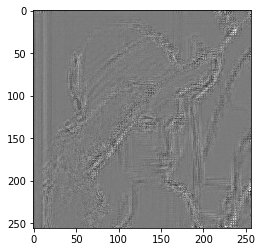

In [576]:
ri_Img = np.divide(RI_Img, cnt_matrix)
plt.imshow(ri_Img, cmap='gray')

reconctruct the high-res image

SyntaxError: invalid syntax (<ipython-input-487-d502bb706e81>, line 42)

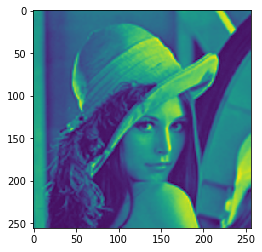

In [577]:
h_Img = ri_Img + X
plt.imshow(h_Img)

plot the difference between scale-up images and original images

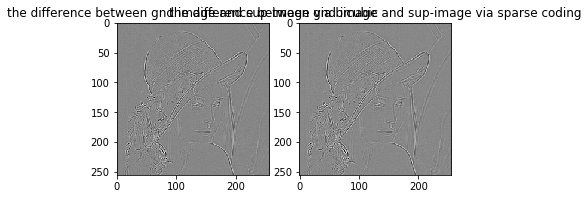

In [578]:
plt.subplot(1,2,1)
plt.title('the difference between gnd image and sup-image via bicubic')
plt.imshow(X-Gnd_Img_ycbcr[:,:,0],cmap = 'gray')
plt.subplot(1,2,2)
plt.title('the difference between gnd image and sup-image via sparse coding')
plt.imshow(h_Img-Gnd_Img_ycbcr[:,:,0],cmap = 'gray')

performance evaluation

In [579]:
psnr = compare_psnr((Gnd_Img_ycbcr[:,:,0]).astype(float),h_Img.astype(float),data_range=h_Img.max() - h_Img.min())
ssim = compare_ssim((Gnd_Img_ycbcr[:,:,0]).astype(float),h_Img.astype(float),data_range=h_Img.max() - h_Img.min())
print('srsc_v2_upscale_3, psnr:', psnr)
print('srsc_v2_upscale_3, ssim:', ssim)

srsc_v2_upscale_3, psnr: 28.94270280877113
srsc_v2_upscale_3, ssim: 0.8947204681900248


In [580]:
psnr = compare_psnr((Gnd_Img_ycbcr[:,:,0]).astype(float),X.astype(float),data_range=Bi_Img.max() - Bi_Img.min())
ssim = compare_ssim((Gnd_Img_ycbcr[:,:,0]).astype(float),X.astype(float),data_range=Bi_Img.max() - Bi_Img.min())
print('bicubic_upscale_2, psnr:', psnr)
print('bicubic_upscale_2, ssim:', ssim)

bicubic_upscale_2, psnr: 28.97314295106966
bicubic_upscale_2, ssim: 0.8954265719724004
